In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Conv2D, Layer, Reshape, Dropout, LeakyReLU, BatchNormalization, Flatten
from keras.initializers import RandomNormal
from sklearn import datasets
import sympy
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display
import glob
from PIL import Image
import datetime

# mlflow tools
import mlflow
from mlflow.tracking import MlflowClient

2023-02-21 22:33:31.237936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 22:33:31.237976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext tensorboard

In [3]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/GAN/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(log_dir)

2023-02-21 22:33:33.355387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ludoboz/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-21 22:33:33.355435: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 22:33:33.355454: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2023-02-21 22:33:33.355682: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset

In [4]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = 'faces/without_mask'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == 'seed9090.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

 91%|█████████ | 9090/10000 [04:08<00:24, 36.51it/s]


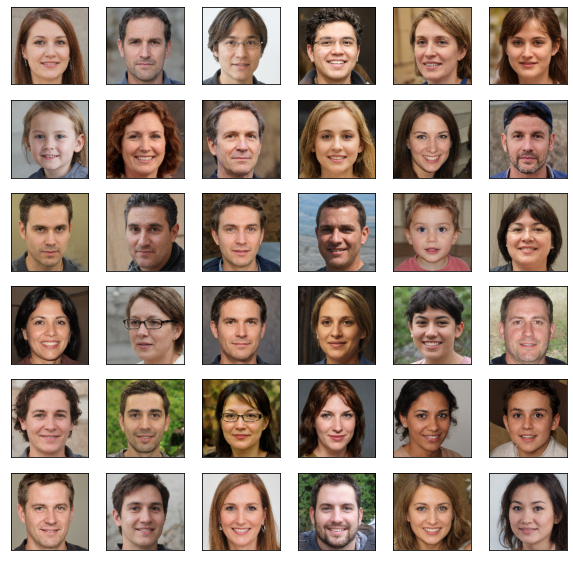

In [5]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)

### Classical GAN

In [6]:
class generator():

    def __init__(self, gen_init_layer_size, z_dim):

        super(generator, self).__init__()
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.gen_weight = RandomNormal(mean=0., stddev=1.0)
        self.input = Input(shape=self.z_dim)        

    def build_gen(self):

        x = Dense(np.prod(self.gen_init_layer_size), use_bias=False, input_shape=(self.z_dim,))(self.input)
        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)  
        
        # Downsampling
        x = Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
        x = Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = LeakyReLU()(x)

        # Upsampling
        x = Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
        x = Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
        x = Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
        x = BatchNormalization()(x)        
        x = Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
        x = Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh')(x)

        output = x
            
        return Model(self.input, output, name = 'Generator_Network')

In [7]:
# class generator():

#     def __init__(self, gen_init_layer_size, z_dim):

#         super(generator, self).__init__()
#         self.gen_init_layer_size = gen_init_layer_size
#         self.z_dim = z_dim
#         self.gen_weight = RandomNormal(mean=0., stddev=1.0)
#         self.input = Input(shape=self.z_dim)
        

#     def build_gen(self):

#         x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, 
#                           input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)
#         x = BatchNormalization()(x)
#         x = LeakyReLU()(x)
#         x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        
#         x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)
#         x = BatchNormalization()(x)
#         x = LeakyReLU()(x)
#         x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)
#         x = BatchNormalization()(x)
#         x = LeakyReLU()(x)
#         x = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')(x) 

#         output = x
            
#         return Model(self.input, output, name = 'Generator_Network')

In [8]:
# Defining generator network

gen_init_layer_size = (128,128,3)
z_dim = 100

z_noise = tf.random.normal([6, z_dim])
gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
gen_net = gen.build_gen()
generated_image = gen_net(z_noise)

#plt.imshow(generated_image[0, :, :, 0], cmap='gray')
gen_net.summary()

Model: "Generator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                 

In [9]:
#gen_net.trainable_variables

In [10]:
class discriminator():
    def __init__(self, disc_input_shape):
        
        super(discriminator, self).__init__() 
        self.disc_input_shape = disc_input_shape
        #self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        self.input = Input(shape=self.disc_input_shape)    
              

    def build_disc(self):

        x = Conv2D(128,4, strides=2, padding='same', input_shape=self.disc_input_shape,
                   kernel_initializer='he_normal', use_bias=False)(self.input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dense(1,activation = 'sigmoid')(x)

        output = x

        return Model(self.input, output, name = 'Discriminator_Network')  

In [11]:
# class discriminator():
#     def __init__(self, disc_input_shape):
        
#         super(discriminator, self).__init__() 
#         self.disc_input_shape = disc_input_shape
#         #self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
#         self.input = Input(shape=self.disc_input_shape)    
              

#     def build_disc(self):
        
#         x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)
#         x = LeakyReLU()(x)
#         x = Dropout(0.3)(x)
#         x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)
#         x = LeakyReLU()(x)
#         x = Dropout(0.3)(x)
#         x = Flatten()(x)
#         x = Dense(1)(x)#, kernel_initializer = self.disc_weight)

#         output = x

#         return Model(self.input, output, name = 'Discriminator_Network')  

In [12]:
# Defining discriminator network
disc_input_shape = (128,128,3)
disc = discriminator(disc_input_shape = disc_input_shape)
disc_net = disc.build_disc()

a = tf.random.normal([128,128,3])
a = tf.expand_dims(a, axis = 0)
#print(disc_net(a))

disc_net.summary()

Model: "Discriminator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                             

In [13]:
#disc_net.trainable_weights

In [14]:
class Trainer():

    def __init__(self, x_train, gen_net, disc_net, gen_init_layer_size, z_dim, disc_input_shape, batch_size, writer, log_dir, logging = True):
        super(Trainer, self).__init__()
        self.x_train = x_train
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.disc_input_shape = disc_input_shape
        self.gen_opt = tf.keras.optimizers.RMSprop(lr=.0001,clipvalue=1.0,decay=1e-8)
        self.disc_opt = tf.keras.optimizers.RMSprop(lr=.0001,clipvalue=1.0,decay=1e-8)#tf.keras.optimizers.Adam(1e-4) 
        self.batch_size = batch_size      
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits = False) 
        self.gen_net = gen_net 
        self.disc_net = disc_net  
        self.writer = writer  
        self.logging= logging  
        self.log_dir = log_dir

        self.g_loss = []
        self.d_loss = []
    
    def gen_loss(self, fake_out):
        return self.loss(tf.ones_like(fake_out), fake_out)


    def disc_loss(self, img, fake_out):

        real_loss = self.loss(tf.ones_like(img), img)
        fake_loss = self.loss(tf.zeros_like(fake_out), fake_out)

        total_loss = real_loss + fake_loss
        return total_loss   


    def generate_and_save_images(self, model, epoch, test_input):
        
        predictions = model(test_input, training=False)

        plt.figure(figsize=(10,10))

        for i, image in enumerate(predictions, 1):
            try:
                plt.subplot(4, 4, i)
                plt.imshow(image[:, :, 0], cmap='gray')
            except ValueError:
                break       
        
        plt.savefig(self.log_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()


    def train_step(self, image):

        noise = tf.random.normal([self.batch_size, self.z_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            generated_images = self.gen_net(noise, training=True)

            real_out = self.disc_net(image, training = True)
            fake_out = self.disc_net(generated_images, training = True)

            gen_loss = self.gen_loss(fake_out)
            disc_loss = self.disc_loss(real_out, fake_out)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.gen_net.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.disc_net.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_of_generator, self.gen_net.trainable_variables))
        self.disc_opt.apply_gradients(zip(gradients_of_discriminator, self.disc_net.trainable_variables))
            
        return gen_loss, disc_loss


    def learn(self, epochs):

        self.g_loss_ep, self.d_loss_ep = [],[]

        with tqdm(range(epochs)) as tepochs:

            for epoch in tepochs:

                #print(f'EPOCH {epoch+1}')

                i = 0

                for j, batch_img in enumerate(self.x_train):

                    gl, dl = self.train_step(batch_img)                

                    i += 1

                    self.g_loss.append(gl)
                    
                    self.d_loss.append(dl)

                    with self.writer.as_default():
                        # save for tensorboard
                        tf.summary.scalar('Generator loss', data=gl, step=epoch* len(self.x_train) + j)
                        tf.summary.scalar('Discriminator loss', data=dl, step=epoch* len(self.x_train) + j)

                    # log the reward with mlflow
                # if self.logging:
                #     mlflow.log_metric('Generator loss', gl, step=epoch* len(self.x_train) + j)
                #     mlflow.log_metric('Discriminator loss', dl, step=epoch* len(self.x_train) + j)

                self.g_loss_ep.append(np.mean(self.g_loss))
                self.d_loss_ep.append(np.mean(self.d_loss))

                # produce images 
                display.clear_output(wait=True)
                self.generate_and_save_images(self.gen_net, epoch + 1, tf.random.normal([self.batch_size, self.z_dim]))  

                # save model with tensorflow
                if self.logging:            
                    with self.writer.as_default():
                        tf.saved_model.save(self.gen_net, self.log_dir + f'generator_network')
                        tf.saved_model.save(self.disc_net, self.log_dir + f'discriminator_network')    

            # saving losses
            np.save(self.log_dir + 'gen_loss.npy',self.g_loss_ep) 
            np.save(self.log_dir + 'disc_loss.npy',self.d_loss_ep) 
                
        
        # print(len(self.g_loss))
        # plt.figure(figsize=(15, 8))
        # plt.plot(np.arange(len(self.g_loss)), self.g_loss, color = 'Red', label = 'Generator Loss')
        # plt.plot(np.arange(len(self.d_loss)), self.d_loss, color = 'Blue', label = 'Discriminator Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend(loc = 'upper right')
        # plt.show()

## Training

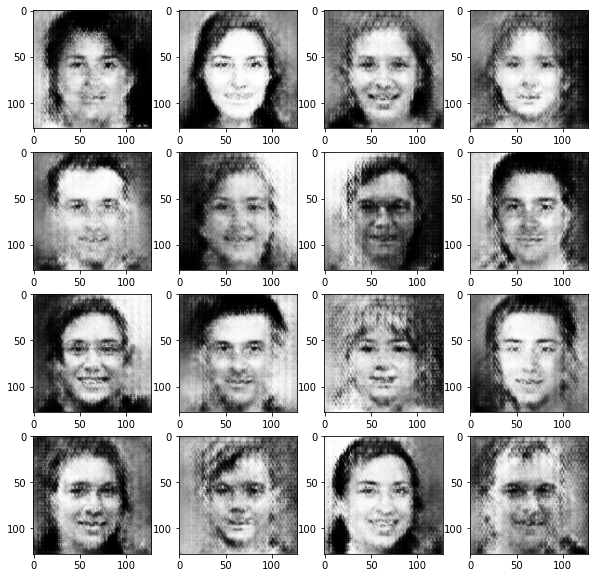

INFO:tensorflow:Assets written to: logs/GAN/20230221-223333/generator_network/assets
INFO:tensorflow:Assets written to: logs/GAN/20230221-223333/discriminator_network/assets


 67%|██████▋   | 4/6 [13:13:36<6:36:48, 11904.14s/it]


KeyboardInterrupt: 

In [15]:
z_dim = 100
batch_size = 32
buffer_size = 10000
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(_img)).shuffle(buffer_size).batch(batch_size)
epochs = 6

gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
gen_net = gen.build_gen()
disc = discriminator(disc_input_shape = disc_input_shape)
disc_net = disc.build_disc()
    
# training
trainer = Trainer(x_train=train_dataset, gen_net=gen_net, disc_net=disc_net, gen_init_layer_size=gen_init_layer_size, 
                    z_dim=z_dim, disc_input_shape=disc_input_shape, batch_size=batch_size, writer=summary_writer, 
                    log_dir=log_dir)

%tensorboard --logdir logs/

trainer.learn(epochs)

In [ ]:
# mlflow experiment settings
# client = MlflowClient()
# experiments = client.list_experiments()
# experiment_name = 'Classical GAN'
# #experiment_id = client.create_experiment(experiment_name)
# #client.set_experiment_tag(experiment_id, 'GAN', 'GM')
# print('Setting up experiment')
# experiment = client.get_experiment_by_name(experiment_name)
# experiment = mlflow.set_experiment(experiment_name=experiment_name)
# experiment_id = experiment.experiment_id
# run_name = 'Run'
# i=0

# with mlflow.start_run(run_name=run_name):
#     # setting up generator and actor networks
#     gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
#     gen_net = gen.build_gen()
#     disc = discriminator(disc_input_shape = disc_input_shape)
#     disc_net = disc.build_disc()

#     # starting mlflow run
#     with mlflow.start_run(run_name=f'{run_name}_{i}', nested=True) as run:
        
#         # training
#         trainer = Trainer(x_train=train_dataset, gen_net=gen_net, disc_net=disc_net, gen_init_layer_size=gen_init_layer_size, 
#                           z_dim=z_dim, disc_input_shape=disc_input_shape, batch_size=batch_size, writer=summary_writer, 
#                           log_dir=log_dir)

#         %tensorboard --logdir logs/

#         trainer.learn(epochs)
        
#         # log and save the model in mlflow
#         print('Saving models in mlflow...')
#         models = ['generator_network', 'discriminator_network']
#         artifact_path = f'mlruns/{experiment_id}/{run.info.run_id}/'
#         for m in models:
#             mlflow.tensorflow.save_model(tf_saved_model_dir = log_dir + m,
#                                          tf_meta_graph_tags = None,
#                                          tf_signature_def_key = "serving_default",
#                                          path = artifact_path + "artifacts/" + m) 
#    i+=1

### GIF

In [ ]:
# fp_in = "path/image_at_epoch_*.png"
# fp_out = "path/GAN.gif"

# imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
# img = next(imgs)  
# img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=150, loop=0)